In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers as opt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import losses
import pandas as pd

In [3]:
DATA_PATH="./Vowel_Data/Formant/"
n_time_sample=25

In [3]:
seed=0

In [156]:
def get_formant(file_path,max_len=n_time_sample):
    formant=pd.read_csv(file_path,
                delim_whitespace=True,
                header=None,
                names=["time","F1","F2","F3","F4","F5"],
                dtype=np.float64,
                na_values="--undefined--")
    if (max_len > formant.shape[0]):
        required_rows=max_len-formant.shape[0]
        new_data=pd.DataFrame(np.zeros((required_rows,6)),columns=["time","F1","F2","F3","F4","F5"])  #empty structure to configure
        time_step=formant.iloc[1]['time']-formant.iloc[0]['time']
        new_data['time']=[formant.iloc[-1]['time']+i*time_step for i in range(1,required_rows+1)]   #new time will incremented as previous time data
        new_data.iloc[:,1:]=formant.iloc[-1,1:].values  #formant values of last existing sample is taken as new formant values
        formant=formant.append(new_data,ignore_index=True)  #new data is appended to the existing
    else:
        formant=formant.iloc[:max_len]  #truncate up to fixed length
    return formant

def get_all_formants(path=DATA_PATH):
    labels=labels=sorted(os.listdir(path))
    all_formant=pd.DataFrame() #empty dataframe to store all_formants
    
    for label_index,label in enumerate(labels):
        folder_formant=pd.DataFrame() #empty dataframe to store formants of indivuals vowels/words i.e. folders

        formant_files=[path + label + '/' + file for file in sorted(os.listdir(path+'/'+label))]
        for file in tqdm(formant_files,"Reading Formants of label -'{}'".format(label)):
            #print(file)
            individual_formant=get_formant(file_path=file)
            folder_formant=folder_formant.append(individual_formant,ignore_index=True)
        
        folder_formant['label']=label_index  #new columns for encoding label
        
        all_formant=all_formant.append(folder_formant,ignore_index=True)
        
    return all_formant

In [184]:
def get_train_test(split_ratio=0.8,random_state=42):
    all_formants=get_all_formants()
    
    X=all_formants.drop(labels=['label'],axis=1).values
    y=all_formants['label'].values

    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True,stratify=y)

In [185]:
all_formants=get_all_formants()

Reading Formants of label -'Formant7': 100%|██████████| 40/40 [00:00<00:00, 331.70it/s]


In [186]:
all_formants.head()

,time,F1,F2,F3,F4,F5,label
0,0.025,705.97,1456.68,2400.93,3665.61,4788.23,0
1,0.031,698.49,1496.51,2366.53,3721.44,4786.20,0
2,0.038,670.76,1514.62,2428.13,3774.71,4719.93,0
3,0.044,666.49,1524.23,2439.99,3764.21,4651.84,0
4,0.050,667.40,1524.64,2409.82,3699.78,4696.84,0


In [162]:
help(all_formants.drop)

Help on method drop in module pandas.core.frame:

drop(labels=None, axis=0, index=None, columns=None, level=None, inplace=False, errors='raise') method of pandas.core.frame.DataFrame instance
    Drop specified labels from rows or columns.
    
    Remove rows or columns by specifying label names and corresponding
    axis, or by specifying directly index or column names. When using a
    multi-index, labels on different levels can be removed by specifying
    the level.
    
    Parameters
    ----------
    labels : single label or list-like
        Index or column labels to drop.
    axis : {0 or 'index', 1 or 'columns'}, default 0
        Whether to drop labels from the index (0 or 'index') or
        columns (1 or 'columns').
    index : single label or list-like
        Alternative to specifying axis (``labels, axis=0``
        is equivalent to ``index=labels``).
    columns : single label or list-like
        Alternative to specifying axis (``labels, axis=1``
        is equivale

In [167]:
X=all_formants.drop(labels=['label'],axis=1)
y=all_formants['label']

In [173]:
X.shape[0]

7000

In [171]:
len(y)

7000

In [168]:
all_formants

,time,F1,F2,F3,F4,F5,label
0,0.025,705.97,1456.68,2400.93,3665.61,4788.23,0
1,0.031,698.49,1496.51,2366.53,3721.44,4786.20,0
2,0.038,670.76,1514.62,2428.13,3774.71,4719.93,0
3,0.044,666.49,1524.23,2439.99,3764.21,4651.84,0
4,0.050,667.40,1524.64,2409.82,3699.78,4696.84,0
...,...,...,...,...,...,...,...
6995,0.150,417.50,941.66,2662.24,4044.07,4497.17,6
6996,0.156,420.04,928.12,2672.68,4041.29,4492.86,6
6997,0.163,436.54,879.28,2679.17,4066.78,4541.83,6
6998,0.169,493.13,781.98,2777.38,4080.27,4549.05,6


In [154]:
help(train_test_split)

Help on function train_test_split in module sklearn.model_selection._split:

train_test_split(*arrays, **options)
    Split arrays or matrices into random train and test subsets
    
    Quick utility that wraps input validation and
    ``next(ShuffleSplit().split(X, y))`` and application to input data
    into a single call for splitting (and optionally subsampling) data in a
    oneliner.
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    *arrays : sequence of indexables with same length / shape[0]
        Allowed inputs are lists, numpy arrays, scipy-sparse
        matrices or pandas dataframes.
    
    test_size : float, int or None, optional (default=None)
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to the
        complement of the train size. If ``train_s

In [114]:
labels,label_indices,_=get_labels(path=DATA_PATH)
for label_index,label in enumerate(labels):
    print(label)
    print(label_index)

Formant1
0
Formant2
1
Formant3
2
Formant4
3
Formant5
4
Formant6
5
Formant7
6


In [72]:
formant=pd.read_csv(DATA_PATH+'/Formant1/vowel1_1_Formant_frq.txt',
                delim_whitespace=True,
                header=None,
                names=["time","F1","F2","F3","F4","F5"],
                dtype=np.float64,
                na_values="--undefined--")

In [126]:
a=pd.DataFrame()

In [131]:
a=a.append(formant,ignore_index=True)

In [132]:
a.shape

(66, 7)

In [130]:
formant['label']=1

In [133]:
a

,time,F1,F2,F3,F4,F5,label
0,0.025,704.03,829.93,2755.50,3452.57,4004.47,0
1,0.031,708.76,804.90,2817.68,3472.35,4033.76,0
2,0.038,661.62,787.50,2854.43,3490.48,4090.51,0
3,0.044,369.13,770.09,2814.76,3510.33,3989.43,0
4,0.050,75.33,225.39,1358.25,3023.90,3645.75,0
...,...,...,...,...,...,...,...
61,0.200,557.75,921.86,2712.78,3603.84,4715.16,1
62,0.206,557.75,921.86,2712.78,3603.84,4715.16,1
63,0.212,557.75,921.86,2712.78,3603.84,4715.16,1
64,0.218,557.75,921.86,2712.78,3603.84,4715.16,1


In [101]:
formant.shape

(33, 6)

In [94]:
formant.iloc[:20].shape

(20, 6)

In [58]:
formant.loc[2:5]

,time,F1,F2,F3,F4,F5
2,0.038,661.62,787.50,2854.43,3490.48,4090.51
3,0.044,369.13,770.09,2814.76,3510.33,3989.43
4,0.050,75.33,225.39,1358.25,3023.90,3645.75
5,0.056,353.91,537.73,2206.67,3293.20,3757.69


In [59]:
formant.iloc[-1]['time']

0.19399999999999998

In [27]:
new=pd.DataFrame(np.zeros((5,6)),columns=["time","F1","F2","F3","F4","F5"])

In [34]:
new['time']=[5, 6, 7, 8, 9]

In [76]:
time_step=formant.iloc[1]['time']-formant.iloc[0]['time']
new['time']=[formant.iloc[-1]['time']+i*time_step for i in range(1,6)]

In [87]:
new.iloc[:,1:]=formant.iloc[-1,1:].values

In [86]:
formant.iloc[-1,1:].values

array([ 557.75,  921.86, 2712.78, 3603.84, 4715.16])

In [88]:
new

,time,F1,F2,F3,F4,F5
0,0.200,557.75,921.86,2712.78,3603.84,4715.16
1,0.206,557.75,921.86,2712.78,3603.84,4715.16
2,0.212,557.75,921.86,2712.78,3603.84,4715.16
3,0.218,557.75,921.86,2712.78,3603.84,4715.16
4,0.224,557.75,921.86,2712.78,3603.84,4715.16


In [92]:
formant=formant.append(new,ignore_index=True)

In [91]:
df_new.shape

(33, 6)

In [202]:
X_train, X_test, y_train, y_test=get_train_test()
y_train_hot=to_categorical(y_train)
y_test_hot=to_categorical(y_test)

Reading Formants of label -'Formant7': 100%|██████████| 40/40 [00:00<00:00, 342.83it/s]


In [199]:
X_train.shape

(5600, 6)

In [200]:
X_test.shape

(1400, 6)

In [188]:
y_train

array([5, 2, 3, ..., 0, 2, 3])

In [201]:
y_train_hot=to_categorical(y_train)

In [190]:
y_train_hot

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [196]:
X_train.shape

(5600, 6)

In [23]:
np.random.seed(seed)

X_train, X_test, y_train, y_test=get_train_test()
tot_no_FORMANT=X_train.shape[1]*X_train.shape[2]
X_train=X_train.reshape((X_train.shape[0],tot_no_FORMANT))
X_test=X_test.reshape(X_test.shape[0],tot_no_MFCC)
y_train_hot=to_categorical(y_train)
y_test_hot=to_categorical(y_test)

ValueError: Object arrays cannot be loaded when allow_pickle=False

In [209]:
model_v=Sequential()
model_v.add(Dense(128, activation='tanh', input_shape=(6,)))
model_v.add(Dense(64, activation='tanh'))
model_v.add(Dense(32, activation='tanh'))
model_v.add(Dense(16, activation='tanh'))
model_v.add(Dense(7, activation='softmax'))

In [210]:
model_v.compile(
    #optimizer=opt.SGD(learning_rate=0.005,momentum=0.9),
    optimizer=opt.Adam(learning_rate=0.005),
    #loss=losses.CategoricalCrossentropy(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [211]:
history_v=model_v.fit(X_train, y_train_hot, epochs=50, batch_size=X_train.shape[0], validation_data=(X_test,y_test_hot))

Epoch 1/50
1/1 [==============================] - 0s 144ms/step - loss: 2.1963 - accuracy: 0.1550 - val_loss: 2.5554 - val_accuracy: 0.1429
Epoch 2/50
1/1 [==============================] - 0s 53ms/step - loss: 2.5647 - accuracy: 0.1429 - val_loss: 2.0047 - val_accuracy: 0.1407
Epoch 3/50
1/1 [==============================] - 0s 52ms/step - loss: 2.0089 - accuracy: 0.1423 - val_loss: 1.8994 - val_accuracy: 0.2093
Epoch 4/50
1/1 [==============================] - 0s 49ms/step - loss: 1.8992 - accuracy: 0.2202 - val_loss: 1.9246 - val_accuracy: 0.1414
Epoch 5/50
1/1 [==============================] - 0s 48ms/step - loss: 1.9211 - accuracy: 0.1430 - val_loss: 1.9385 - val_accuracy: 0.1450
Epoch 6/50
1/1 [==============================] - 0s 61ms/step - loss: 1.9366 - accuracy: 0.1391 - val_loss: 1.9089 - val_accuracy: 0.1614
Epoch 7/50
1/1 [==============================] - 0s 57ms/step - loss: 1.9059 - accuracy: 0.1643 - val_loss: 1.8642 - val_accuracy: 0.2514
Epoch 8/50
1/1 [==========

In [212]:
history_dict=history_v.history

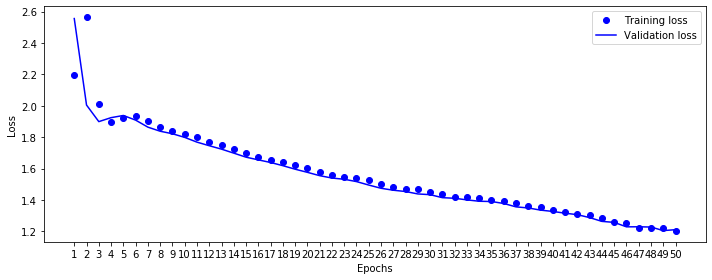

In [213]:
loss_v=history_dict['loss']
val_loss_v=history_dict['val_loss']
epochs=range(1,len(loss_v)+1)

plt.figure(figsize=(10,4))
plt.plot(epochs,loss_v,'bo',label='Training loss')
plt.plot(epochs,val_loss_v,'b',label='Validation loss')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
#plt.savefig('./Result/New_without_CNN/loss_vowel_128_64_32_16_tanh_softmax_adam_batch200.svg',format='svg', dpi=600)

<Figure size 432x288 with 0 Axes>

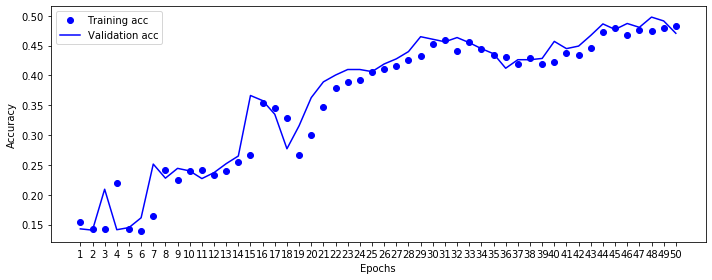

In [214]:
plt.clf()
acc_v=history_dict['accuracy']
val_acc_v=history_dict['val_accuracy']

plt.figure(figsize=(10,4))
plt.plot(epochs,acc_v,'bo',label='Training acc')
plt.plot(epochs,val_acc_v,'b',label='Validation acc')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
#plt.savefig('./Result/New_without_CNN/accuracy_vowel_128_64_32_16_tanh_softmax_adam_batch200.svg',format='svg', dpi=600)

In [81]:
DATA_PATH="./Word_Data/Word/"
n_time_sample=44

In [82]:
def get_labels(path=DATA_PATH):
    labels=sorted(os.listdir(path))
    label_indices=np.arange(0,len(labels))
    return labels, label_indices, to_categorical(label_indices)

def speech2mfcc(file_path,max_len=n_time_sample):
    wave, sr= librosa.load(file_path, mono=True, sr=None)
    mfcc=librosa.feature.mfcc(wave,sr=sr,n_mfcc=n_MFCC)
    if (max_len > mfcc.shape[1]): #.shape[1], 1-->column
        pad_width=max_len-mfcc.shape[1]
        mfcc=np.pad(mfcc,pad_width=((0,0),(0,pad_width)),mode='constant')
    else:
        mfcc=mfcc[:,:max_len]
    return mfcc

def save_data_to_array(path=DATA_PATH, max_len=n_time_sample):
    labels,_,_=get_labels(path)

    for label in labels:
        mfcc_vectors=[]

        speechfiles=[path + label + '/' + speech for speech in sorted(os.listdir(path+'/'+label))]
        for speech in tqdm(speechfiles,"Saving vectors to label -'{}'".format(label)):
            mfcc=speech2mfcc(speech,max_len=max_len)
            mfcc_vectors.append(mfcc)
            
        np.save(label+'.npy',mfcc_vectors)
        
def get_train_test(split_ratio=0.8,random_state=seed):
    labels,indices,_=get_labels(DATA_PATH)

    X=np.load(labels[0]+'.npy')
    y=np.zeros(X.shape[0])

    for i,label in enumerate(labels[1:]):
        x=np.load(label+'.npy')
        X=np.vstack((X,x))
        y=np.append(y,np.full(x.shape[0],fill_value=(i+1)))
    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True,stratify=y)

In [83]:
save_data_to_array()

Saving vectors to label -'Word7': 100%|██████████| 40/40 [00:00<00:00, 105.70it/s]


In [106]:
np.random.seed(seed)

X_train, X_test, y_train, y_test=get_train_test()
tot_no_MFCC=X_train.shape[1]*X_train.shape[2]
X_train=X_train.reshape((X_train.shape[0],-1))
X_test=X_test.reshape(X_test.shape[0],-1)
y_train_hot=to_categorical(y_train)
y_test_hot=to_categorical(y_test)

In [119]:
model_w=Sequential()
model_w.add(Dense(128, activation='tanh', input_shape=(tot_no_MFCC,)))
model_w.add(Dense(64, activation='tanh'))
model_w.add(Dense(32, activation='tanh'))
model_w.add(Dense(16, activation='tanh'))
model_w.add(Dense(7, activation='softmax'))

In [120]:
model_w.compile(
    optimizer=opt.Adam(learning_rate=0.005),
    #loss=losses.CategoricalCrossentropy(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [121]:
history_w=model_w.fit(X_train, y_train_hot, epochs=50, batch_size=X_train.shape[0], validation_data=(X_test,y_test_hot))

Epoch 1/50
1/1 [==============================] - 0s 150ms/step - loss: 2.1414 - accuracy: 0.1116 - val_loss: 1.9797 - val_accuracy: 0.1964
Epoch 2/50
1/1 [==============================] - 0s 56ms/step - loss: 1.8981 - accuracy: 0.2366 - val_loss: 1.9269 - val_accuracy: 0.2143
Epoch 3/50
1/1 [==============================] - 0s 65ms/step - loss: 1.8685 - accuracy: 0.2277 - val_loss: 1.8362 - val_accuracy: 0.2857
Epoch 4/50
1/1 [==============================] - 0s 45ms/step - loss: 1.7987 - accuracy: 0.3348 - val_loss: 1.7761 - val_accuracy: 0.3393
Epoch 5/50
1/1 [==============================] - 0s 62ms/step - loss: 1.6728 - accuracy: 0.3973 - val_loss: 1.7242 - val_accuracy: 0.3571
Epoch 6/50
1/1 [==============================] - 0s 79ms/step - loss: 1.6092 - accuracy: 0.3705 - val_loss: 1.6231 - val_accuracy: 0.4464
Epoch 7/50
1/1 [==============================] - 0s 71ms/step - loss: 1.5280 - accuracy: 0.4866 - val_loss: 1.6170 - val_accuracy: 0.4286
Epoch 8/50
1/1 [==========

In [88]:
history_dict=history_w.history

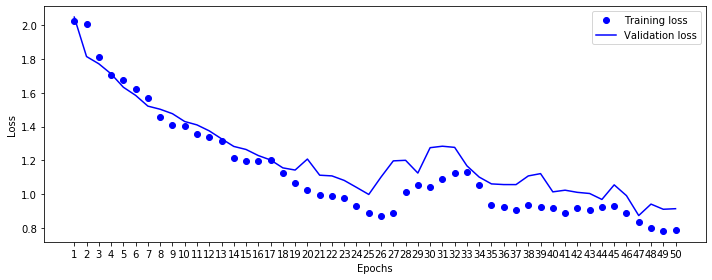

In [89]:
loss_w=history_dict['loss']
val_loss_w=history_dict['val_loss']
epochs=range(1,len(loss_v)+1)

plt.figure(figsize=(10,4))
plt.plot(epochs,loss_w,'bo',label='Training loss')
plt.plot(epochs,val_loss_w,'b',label='Validation loss')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
#plt.savefig('./Result/New_without_CNN/loss_vowel_128_64_32_16_tanh_softmax_adam_batch200.svg',format='svg', dpi=600)

<Figure size 432x288 with 0 Axes>

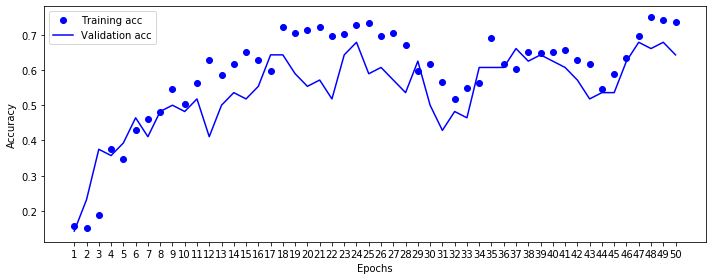

In [90]:
plt.clf()
acc_w=history_dict['accuracy']
val_acc_w=history_dict['val_accuracy']

plt.figure(figsize=(10,4))
plt.plot(epochs,acc_w,'bo',label='Training acc')
plt.plot(epochs,val_acc_w,'b',label='Validation acc')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
#plt.savefig('./Result/New_without_CNN/accuracy_vowel_128_64_32_16_tanh_softmax_adam_batch200.svg',format='svg', dpi=600)

In [91]:
#COMPARE

In [92]:
epochs=range(1,len(loss_v)+1)

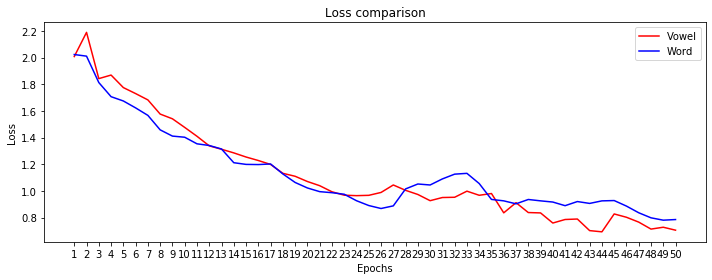

In [93]:
plt.figure(figsize=(10,4))
plt.plot(epochs,loss_v,'r',label='Vowel')
plt.plot(epochs,loss_w,'b',label='Word')
plt.title('Loss comparison')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
#plt.savefig('./Result/New_without_CNN/loss_compare_diff_len_128_64_32_16_tanh_softmax_rmsprop_batch128'+'.svg',format='svg',dpi=600)

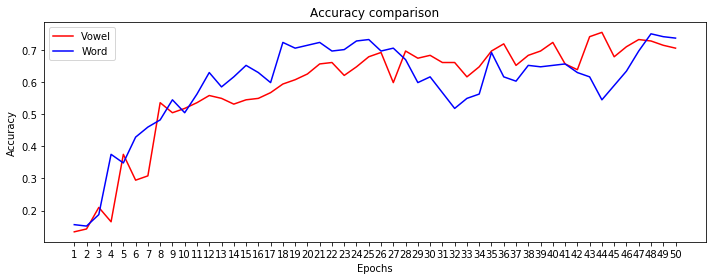

In [94]:
plt.figure(figsize=(10,4))
plt.plot(epochs,acc_v,'r',label='Vowel')
plt.plot(epochs,acc_w,'b',label='Word')
plt.title('Accuracy comparison')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
#plt.savefig('./Result/New_without_CNN/accuracy_compare_diff_len_128_64_32_16_tanh_softmax_rmsprop_batch128'+'.svg',format='svg',dpi=600)